**Importing necessary packages**

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Input, Dense, Reshape, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import pickle
import pandas as pd
from difflib import SequenceMatcher
import os

In [2]:
img_height = 256
img_width = 256
channels = 3
batch_size = 32

In [3]:
data = os.listdir('/content/drive/MyDrive/flipkart/data/images')
print(len(data))

18330


**Load the data**

In [4]:
train_datagen = ImageDataGenerator(#rotation_range=40,
                                   #width_shift_range=0.2,
                                   #height_shift_range=0.2,
                                   rescale=1./255,
                                   #shear_range=0.2,
                                   #zoom_range=0.2,
                                   #horizontal_flip=True,
                                   #fill_mode='nearest',
                                   validation_split=0.2)

In [5]:
training_set = train_datagen.flow_from_directory(
     '/content/drive/MyDrive/flipkart/data',
     target_size = (img_height, img_width),
     batch_size = batch_size,
     class_mode = 'input',
     subset = 'training',
     shuffle=True)

Found 14664 images belonging to 1 classes.


In [6]:
validation_set = train_datagen.flow_from_directory(
     '/content/drive/MyDrive/flipkart/data',
     target_size = (img_height, img_width),
     batch_size = batch_size,
     class_mode = 'input',
     subset = 'validation',
     shuffle=False)

Found 3666 images belonging to 1 classes.


**Model**

In [7]:
input_model = Input(shape=(img_height, img_width, channels))

# Encoder layers
encoder = Conv2D(32, (3,3), padding='same', kernel_initializer='normal')(input_model)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)

encoder = Conv2D(64, (3,3), padding='same', kernel_initializer='normal')(encoder)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)

encoder = Conv2D(64, (3,3), padding='same', kernel_initializer='normal')(input_model)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)

encoder_dim = K.int_shape(encoder)
encoder = Flatten()(encoder)

# Latent Space
latent_space = Dense(16, name='latent_space')(encoder)

# Decoder Layers
decoder = Dense(np.prod(encoder_dim[1:]))(latent_space)
decoder = Reshape((encoder_dim[1], encoder_dim[2], encoder_dim[3]))(decoder)

decoder = Conv2DTranspose(64, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(64, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(32, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(3, (3, 3), padding="same")(decoder)
output = Activation('sigmoid', name='decoder')(decoder)

# Create model object
autoencoder = Model(input_model, output, name='autoencoder')

In [8]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256, 256, 64)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
flatten (Flatten)            (None, 4194304)           0         
_________________________________________________________________
latent_space (Dense)         (None, 16)                67108880  
_________________________________________________________________
dense (Dense)                (None, 4194304)           

In [9]:
# Compile the model
autoencoder.compile(loss="mse", optimizer= Adam(learning_rate=1e-3))

In [10]:
# Fit the model
history = autoencoder.fit_generator(
          training_set,
          steps_per_epoch=training_set.n // batch_size,
          epochs=10,
          validation_data=validation_set,
          validation_steps=validation_set.n // batch_size,
          callbacks = [ModelCheckpoint('/content/drive/MyDrive/models/image_autoencoder_2.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False)])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
458/458 [==============================] - 2744s 6s/step - loss: 0.0735 - val_loss: 0.0702
Epoch 2/10
458/458 [==============================] - 162s 354ms/step - loss: 0.0426 - val_loss: 0.0431
Epoch 3/10
458/458 [==============================] - 157s 344ms/step - loss: 0.0396 - val_loss: 0.0362
Epoch 4/10
458/458 [==============================] - 159s 348ms/step - loss: 0.0362 - val_loss: 0.0349
Epoch 5/10
458/458 [==============================] - 159s 347ms/step - loss: 0.0359 - val_loss: 0.0349
Epoch 6/10
458/458 [==============================] - 159s 348ms/step - loss: 0.0343 - val_loss: 0.0348
Epoch 7/10
458/458 [==============================] - 160s 349ms/step - loss: 0.0333 - val_loss: 0.0338
Epoch 8/10
458/458 [==============================] - 160s 349ms/step - loss: 0.0327 - val_loss: 0.0350
Epoch 9/10
458/458 [==============================] - 156s 341ms/step - loss: 0.0324 - val_loss: 0.0329
Epoch 10/10
458/458 [==============================] - 158s 345ms/

**Model Perfommance**

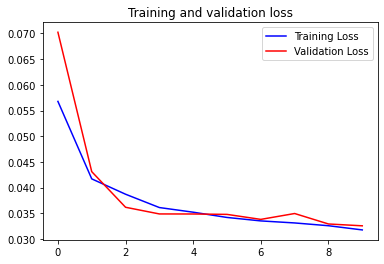

In [11]:
# Plot Accuracy and Loss
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(loss))
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [12]:
autoencoder = load_model('/content/drive/MyDrive/models/image_autoencoder_2.h5', compile=False)

In [13]:
# Predict image function
def predict_image(image_dir, autoencoder):
  raw_image = load_img(image_dir, target_size=(256, 256))
  image = img_to_array(raw_image)
  image = np.expand_dims(image, axis=0)
  image = image / 255.0
  pred = autoencoder.predict(image)
  pred = pred * 255.0
  pred = np.reshape(pred, (256, 256, 3))
  pred = array_to_img(pred)

  return raw_image, pred

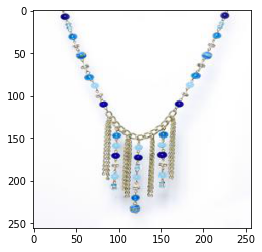

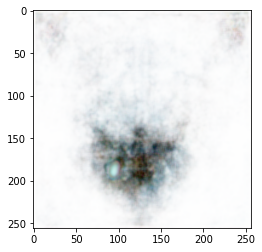

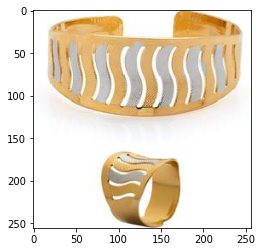

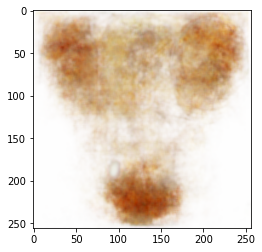

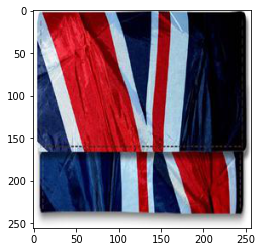

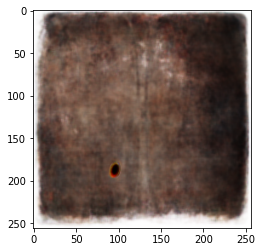

In [17]:
# Predict 3 images from training set
train_imgs = training_set.filepaths[44:47]

for i in train_imgs:
  raw_image, pred_image = predict_image(i, autoencoder)
  
  # Show original image
  plt.imshow(raw_image)
  plt.show()
  
  # Show predicted image
  plt.imshow(pred_image)
  plt.show()

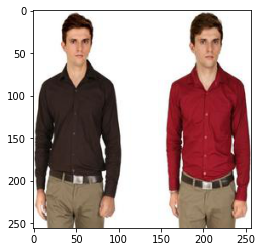

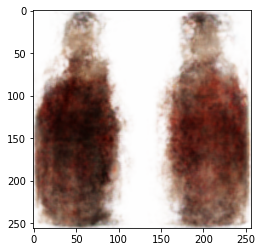

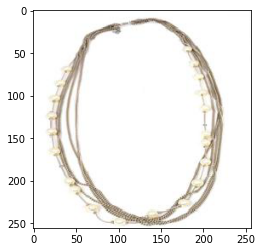

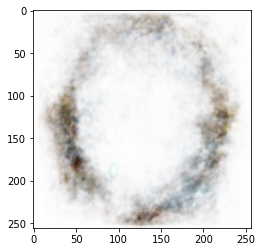

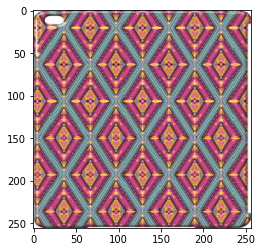

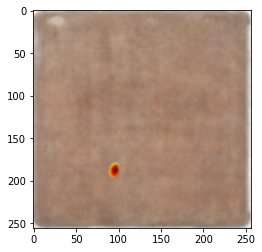

In [19]:
# Predict 3 images from validation set
val_imgs = validation_set.filepaths[6:9]

for i in val_imgs:
  raw_image, pred_image = predict_image(i, autoencoder)
  
  # Show original image
  plt.imshow(raw_image)
  plt.show()
  
  # Show predicted image
  plt.imshow(pred_image)
  plt.show()